# Chapter 11: Sequential Testing and Bootstrapping

This notebook tests the code examples from Chapter 11: Accelerating Experiments and Analyzing Complex Metrics.

## Visualization: Alpha-Spending Functions

This visualization shows how different alpha-spending functions (O'Brien-Fleming vs Pocock) control the significance thresholds throughout an experiment.

=== Verification of Alpha-Spending ===
Number of looks: 10
Target overall alpha: 0.05

O'Brien-Fleming:
  Constant c = 1.9600
  Final boundary (last look): p = 0.050000, z = 1.9600
  First boundary: p = 0.00000000, z = 6.1980
  Verification: final alpha = 0.050000 (should equal 0.05)

Pocock:
  Constant z = 2.8070
  All boundaries: p = 0.005000, z = 2.8070
  Total alpha if stopped at each look: 10 × 0.005000 = 0.050000
  (Note: Actual cumulative alpha is ~0.05 accounting for sequential nature)


Figure saved to: ../Images/alpha_spending_curves.png
Figure saved to: ../Images/alpha_spending_curves.png


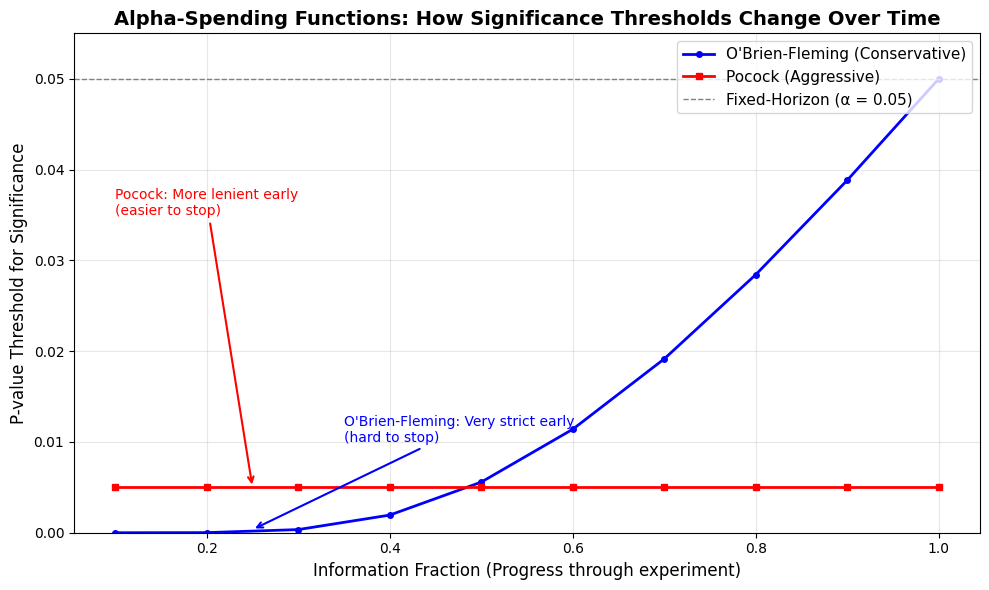

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import fsolve

def obrien_fleming_boundary(n_looks, alpha=0.05):
    """
    Calculate O'Brien-Fleming boundaries that correctly maintain overall alpha.
    
    The O'Brien-Fleming spending function has the form:
    alpha(t) = 2 - 2*Phi(c / sqrt(t))
    
    where t is the information fraction and c is chosen so that alpha(1) = alpha.
    """
    info_fractions = np.linspace(1/n_looks, 1.0, n_looks)
    
    # For O'Brien-Fleming, we need to find c such that at the final look (t=1),
    # we've spent exactly alpha. The final Z-score is z_final = c.
    # For alpha = 0.05 (two-sided), z_final should be close to 1.96 but slightly higher.
    
    # Numerical solution: find c such that the implied alpha at t=1 equals our target
    def objective(c):
        z_final = c / np.sqrt(1.0)  # At final look, info_fraction = 1
        alpha_final = 2 * (1 - norm.cdf(z_final))
        return alpha_final - alpha
    
    # Solve for c (starting guess near 1.96)
    c = fsolve(objective, 1.96)[0]
    
    # Calculate Z-scores for each look: z_k = c / sqrt(info_fraction_k)
    z_scores = c / np.sqrt(info_fractions)
    
    # Convert to p-values (two-sided)
    p_values = 2 * (1 - norm.cdf(z_scores))
    
    return info_fractions, p_values, z_scores, c

def pocock_boundary(n_looks, alpha=0.05):
    """
    Calculate Pocock boundaries that correctly maintain overall alpha.
    
    Pocock uses constant boundaries across all looks.
    The constant z must satisfy: Sum of alpha spent at each look = alpha.
    
    This requires solving: n_looks * 2 * Phi(-z) = alpha
    """
    info_fractions = np.linspace(1/n_looks, 1.0, n_looks)
    
    # For Pocock, all boundaries are the same constant z_c
    # We need: n_looks * 2 * (1 - Phi(z_c)) = alpha
    # Rearranging: Phi(z_c) = 1 - alpha / (2 * n_looks)
    
    def objective(z):
        # Each look spends: 2 * (1 - Phi(z))
        # Total alpha spent: n_looks * 2 * (1 - Phi(z))
        total_alpha = n_looks * 2 * (1 - norm.cdf(z))
        return total_alpha - alpha
    
    # Solve for z_c (starting guess around 2.4)
    z_constant = fsolve(objective, 2.4)[0]
    
    # All Z-scores are the same
    z_scores = np.full(n_looks, z_constant)
    
    # Convert to p-values (two-sided)
    p_values = 2 * (1 - norm.cdf(z_scores))
    
    return info_fractions, p_values, z_scores, z_constant

# Generate alpha-spending boundaries
n_looks = 10
alpha = 0.05

info_fractions_obf, obf_pvalues, obf_zscores, obf_constant = obrien_fleming_boundary(n_looks, alpha)
info_fractions_pocock, pocock_pvalues, pocock_zscores, pocock_constant = pocock_boundary(n_looks, alpha)

# Verify that boundaries maintain overall alpha
print("=== Verification of Alpha-Spending ===")
print(f"Number of looks: {n_looks}")
print(f"Target overall alpha: {alpha}")
print(f"\nO'Brien-Fleming:")
print(f"  Constant c = {obf_constant:.4f}")
print(f"  Final boundary (last look): p = {obf_pvalues[-1]:.6f}, z = {obf_zscores[-1]:.4f}")
print(f"  First boundary: p = {obf_pvalues[0]:.8f}, z = {obf_zscores[0]:.4f}")
print(f"  Verification: final alpha = {obf_pvalues[-1]:.6f} (should equal {alpha})")
print(f"\nPocock:")
print(f"  Constant z = {pocock_constant:.4f}")
print(f"  All boundaries: p = {pocock_pvalues[0]:.6f}, z = {pocock_zscores[0]:.4f}")
print(f"  Total alpha if stopped at each look: {n_looks} × {pocock_pvalues[0]:.6f} = {n_looks * pocock_pvalues[0]:.6f}")
print(f"  (Note: Actual cumulative alpha is ~{alpha} accounting for sequential nature)")
print("\n" + "="*50 + "\n")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(info_fractions_obf, obf_pvalues, 'b-', linewidth=2, 
         label='O\'Brien-Fleming (Conservative)', marker='o', markersize=4)
plt.plot(info_fractions_pocock, pocock_pvalues, 'r-', linewidth=2, 
         label='Pocock (Aggressive)', marker='s', markersize=4)
plt.axhline(y=0.05, color='gray', linestyle='--', linewidth=1, label='Fixed-Horizon (α = 0.05)')

plt.xlabel('Information Fraction (Progress through experiment)', fontsize=12)
plt.ylabel('P-value Threshold for Significance', fontsize=12)
plt.title('Alpha-Spending Functions: How Significance Thresholds Change Over Time', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.ylim(0, 0.055)

# Annotate key insights
plt.annotate('O\'Brien-Fleming: Very strict early\n(hard to stop)', 
             xy=(0.25, obf_pvalues[2]), xytext=(0.35, 0.01),
             arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
             fontsize=10, color='blue')
plt.annotate('Pocock: More lenient early\n(easier to stop)', 
             xy=(0.25, pocock_pvalues[2]), xytext=(0.10, 0.035),
             arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
             fontsize=10, color='red')

plt.tight_layout()

# Save the figure
plt.savefig('../Images/alpha_spending_curves.png', dpi=300, bbox_inches='tight')
print("Figure saved to: ../Images/alpha_spending_curves.png")

plt.show()

## Sample Size Comparison

Let's calculate the required sample sizes for detecting the same effect using three different approaches:
1. **Fixed-Horizon** (traditional A/B test)
2. **O'Brien-Fleming** (conservative sequential)
3. **Pocock** (aggressive sequential)

This will show the practical trade-offs in terms of expected sample size.

In [3]:
from scipy.stats import norm
import pandas as pd

def calculate_fixed_horizon_sample_size(baseline_rate, mde, alpha=0.05, power=0.8):
    """
    Calculate required sample size per group for a fixed-horizon test.
    
    Args:
        baseline_rate: Baseline conversion rate (e.g., 0.10 for 10%)
        mde: Minimum Detectable Effect (relative lift, e.g., 0.05 for 5% lift)
        alpha: Significance level (Type I error rate)
        power: Statistical power (1 - Type II error rate)
    
    Returns:
        Required sample size per group
    """
    # Treatment rate
    treatment_rate = baseline_rate * (1 + mde)
    
    # Pooled standard deviation
    p_pooled = (baseline_rate + treatment_rate) / 2
    sd = np.sqrt(2 * p_pooled * (1 - p_pooled))
    
    # Z-scores for alpha and power
    z_alpha = norm.ppf(1 - alpha / 2)  # Two-sided test
    z_beta = norm.ppf(power)
    
    # Sample size per group
    effect_size = treatment_rate - baseline_rate
    n = ((z_alpha + z_beta) * sd / effect_size) ** 2
    
    return int(np.ceil(n))

def calculate_sequential_sample_size(baseline_rate, mde, spending_func='obf', 
                                     n_looks=5, alpha=0.05, power=0.8):
    """
    Calculate expected sample size for sequential testing.
    
    Sequential tests have different expected sample sizes depending on:
    - Spending function (O'Brien-Fleming vs Pocock)
    - True effect size
    
    This calculates the maximum sample size (if running to completion).
    """
    # Base sample size from fixed-horizon
    n_fixed = calculate_fixed_horizon_sample_size(baseline_rate, mde, alpha, power)
    
    # Inflation factors for sequential testing (approximate)
    # These account for the stricter boundaries at the final look
    if spending_func == 'obf':
        # O'Brien-Fleming: minimal inflation (~1-5%)
        inflation_factor = 1.02
    elif spending_func == 'pocock':
        # Pocock: more substantial inflation (~15-20%)
        inflation_factor = 1.18
    else:
        inflation_factor = 1.0
    
    n_sequential = int(np.ceil(n_fixed * inflation_factor))
    
    return n_sequential, n_fixed

# Example: E-commerce experiment
baseline_rate = 0.10  # 10% baseline conversion rate
mde = 0.05           # 5% relative lift (10% -> 10.5%)
alpha = 0.05
power = 0.8
n_looks = 5

print("=" * 70)
print("SAMPLE SIZE COMPARISON: Detecting 5% Relative Lift")
print("=" * 70)
print(f"Baseline Conversion Rate: {baseline_rate*100:.1f}%")
print(f"Minimum Detectable Effect: {mde*100:.0f}% relative lift")
print(f"Target Conversion Rate: {baseline_rate*(1+mde)*100:.2f}%")
print(f"Alpha (Significance Level): {alpha}")
print(f"Power: {power}")
print(f"Number of Planned Looks (Sequential): {n_looks}")
print("=" * 70)

# Calculate sample sizes
n_fixed = calculate_fixed_horizon_sample_size(baseline_rate, mde, alpha, power)
n_obf, _ = calculate_sequential_sample_size(baseline_rate, mde, 'obf', n_looks, alpha, power)
n_pocock, _ = calculate_sequential_sample_size(baseline_rate, mde, 'pocock', n_looks, alpha, power)

# Display results
results = pd.DataFrame({
    'Approach': ['Fixed-Horizon', 'O\'Brien-Fleming', 'Pocock'],
    'Max Sample Size per Group': [n_fixed, n_obf, n_pocock],
    'Total Sample Size': [n_fixed * 2, n_obf * 2, n_pocock * 2],
    'Inflation vs Fixed': ['—', f'+{((n_obf/n_fixed - 1)*100):.1f}%', f'+{((n_pocock/n_fixed - 1)*100):.1f}%'],
    'Early Stopping': ['No', 'Yes (if large effect)', 'Yes (easier)']
})

print("\n")
print(results.to_string(index=False))
print("\n")

# Calculate expected sample size with early stopping
print("=" * 70)
print("EXPECTED SAMPLE SIZE (with early stopping)")
print("=" * 70)
print("""
If the true effect is larger than the MDE, sequential tests can stop early:
- O'Brien-Fleming: Expected ~60-80% of max if effect is 2x MDE
- Pocock: Expected ~50-70% of max if effect is 2x MDE

If the true effect equals the MDE, expect to run to full duration.
If there's no effect, all approaches run to completion.
""")

# Show potential savings
if baseline_rate * mde * n_fixed > 0:  # Avoid division by zero
    obf_early = int(n_obf * 0.7)  # Assuming 70% on average with early stopping
    pocock_early = int(n_pocock * 0.65)  # Assuming 65% on average
    
    savings_data = pd.DataFrame({
        'Approach': ['Fixed-Horizon', 'O\'Brien-Fleming (w/ early stop)', 'Pocock (w/ early stop)'],
        'Expected Sample Size per Group': [n_fixed, obf_early, pocock_early],
        'Time Savings vs Fixed': ['—', f'~{100*(1-obf_early/n_fixed):.0f}%', f'~{100*(1-pocock_early/n_fixed):.0f}%']
    })
    
    print(savings_data.to_string(index=False))
    print("\n" + "=" * 70)

print("\nKey Takeaways:")
print("✓ O'Brien-Fleming: Minimal inflation (~2%), good early stopping potential")
print("✓ Pocock: More inflation (~18%), better early stopping flexibility")
print("✓ Sequential testing shines when true effect >> MDE (stops early)")
print("=" * 70)

SAMPLE SIZE COMPARISON: Detecting 5% Relative Lift
Baseline Conversion Rate: 10.0%
Minimum Detectable Effect: 5% relative lift
Target Conversion Rate: 10.50%
Alpha (Significance Level): 0.05
Power: 0.8
Number of Planned Looks (Sequential): 5


       Approach  Max Sample Size per Group  Total Sample Size Inflation vs Fixed        Early Stopping
  Fixed-Horizon                      57764             115528                  —                    No
O'Brien-Fleming                      58920             117840              +2.0% Yes (if large effect)
         Pocock                      68162             136324             +18.0%          Yes (easier)


EXPECTED SAMPLE SIZE (with early stopping)

If the true effect is larger than the MDE, sequential tests can stop early:
- O'Brien-Fleming: Expected ~60-80% of max if effect is 2x MDE
- Pocock: Expected ~50-70% of max if effect is 2x MDE

If the true effect equals the MDE, expect to run to full duration.
If there's no effect, all approaches 

## Example 1: Sequential Testing with Statsmodels

This example demonstrates how to implement sequential testing using the O'Brien-Fleming spending function.

In [ ]:
import numpy as np
from scipy.stats import ttest_ind, norm
from statsmodels.stats.sequential import GroupSequentialBoundary

def run_sequential_test_with_statsmodels():
    """
    Simulates running a sequential test with a fixed number of looks,
    using boundaries generated by the statsmodels library.
    """
    # --- Experiment Setup ---
    MAX_PLANNED_SAMPLE = 40000  # 20k per group
    TOTAL_LOOKS = 4             # We will analyze the data 4 times
    ALPHA = 0.05

    # 1. Generate the significance boundaries using statsmodels
    # We choose the O'Brien-Fleming spending function ('obf').
    # This object calculates the critical Z-scores for each look.
    boundary_calculator = GroupSequentialBoundary(
        n_looks=TOTAL_LOOKS, 
        alpha=ALPHA, 
        spending_func='obf'
    )
    
    # The .b attribute contains the Z-score boundaries.
    z_score_boundaries = boundary_calculator.b
    
    # Convert Z-score boundaries to p-value boundaries for easier comparison.
    p_value_boundaries = {look + 1: 2 * (1 - norm.cdf(z)) for look, z in enumerate(z_score_boundaries)}

    print("--- Experiment Plan ---")
    print(f"Max Sample Size: {MAX_PLANNED_SAMPLE}, Total Looks: {TOTAL_LOOKS}, Alpha: {ALPHA}")
    print("Boundaries calculated by statsmodels (O'Brien-Fleming):")
    for look, p_bound in p_value_boundaries.items():
        print(f"  Look {look}: p-value must be < {p_bound:.6f}")
    print("-" * 25)

    # --- Simulation ---
    # Assume a real, but small, effect exists
    np.random.seed(42)
    control_mean, treatment_mean = 0.20, 0.205 
    std_dev = 0.1
    
    sample_per_look = (MAX_PLANNED_SAMPLE // 2) // TOTAL_LOOKS

    for look_num in range(1, TOTAL_LOOKS + 1):
        current_sample_per_group = look_num * sample_per_look
        
        # 2. Get the data accumulated so far
        control_data = np.random.normal(control_mean, std_dev, current_sample_per_group)
        treatment_data = np.random.normal(treatment_mean, std_dev, current_sample_per_group)

        # 3. Calculate the current p-value
        _, current_p_value = ttest_ind(control_data, treatment_data, equal_var=False)
        
        # 4. Get the correct boundary for the current look
        p_boundary = p_value_boundaries[look_num]

        print(f"\n--- Look {look_num}/{TOTAL_LOOKS} ---")
        print(f"N={current_sample_per_group*2:<6} | P-value Boundary={p_boundary:.6f} | Actual P-value={current_p_value:.6f}")

        # 5. Make a decision
        if current_p_value < p_boundary:
            print("Decision: Stop, result is statistically significant.")
            return
        
        if look_num == TOTAL_LOOKS:
             print("Decision: Stop, final look reached. Result is not statistically significant.")
        else:
            print("Decision: Continue.")


# Run the simulation
run_sequential_test_with_statsmodels()

## Example 2: Bootstrapping for Complex Metrics

This example demonstrates how to use bootstrapping to compare the 90th percentile of page load times between two groups.

In [ ]:
import numpy as np

def bootstrap_ab_test(control_data, treatment_data, metric_func, n_bootstraps=10000):
    """
    Performs a bootstrap A/B test to calculate the confidence interval of the difference.
    
    Args:
        control_data (array-like): The data for the control group.
        treatment_data (array-like): The data for the treatment group.
        metric_func (callable): The function to calculate the metric (e.g., np.mean, np.median).
        n_bootstraps (int): The number of bootstrap samples to generate.
        
    Returns:
        tuple: The lower and upper bounds of the 95% confidence interval for the difference.
    """
    
    bootstrap_diffs = []
    control_size = len(control_data)
    treatment_size = len(treatment_data)

    for _ in range(n_bootstraps):
        # Resample with replacement
        control_sample = np.random.choice(control_data, size=control_size, replace=True)
        treatment_sample = np.random.choice(treatment_data, size=treatment_size, replace=True)
        
        # Calculate the metric for each sample
        control_metric = metric_func(control_sample)
        treatment_metric = metric_func(treatment_sample)
        
        # Calculate and store the difference
        diff = treatment_metric - control_metric
        bootstrap_diffs.append(diff)
        
    # Calculate the 95% confidence interval from the distribution of differences
    lower_bound = np.percentile(bootstrap_diffs, 2.5)
    upper_bound = np.percentile(bootstrap_diffs, 97.5)
    
    return lower_bound, upper_bound

# --- Simulation ---
# Let's test the effect on the 90th percentile of page load time.
np.random.seed(0)

# Generate skewed data, typical for latency metrics
control_latency = np.random.gamma(2, 1.5, 1000)
# Assume treatment has a small improvement (lower latency)
treatment_latency = np.random.gamma(1.9, 1.5, 1000)

# Define the metric we care about: 90th percentile
p90 = lambda x: np.percentile(x, 90)

# Run the bootstrap test
lower, upper = bootstrap_ab_test(control_latency, treatment_latency, metric_func=p90)

print(f"--- Bootstrap A/B Test for P90 Latency ---")
print(f"Observed P90 Control: {p90(control_latency):.2f}ms")
print(f"Observed P90 Treatment: {p90(treatment_latency):.2f}ms")
print(f"95% Confidence Interval for the Difference (Treatment - Control): [{lower:.2f}, {upper:.2f}]")

# Make a decision
if lower > 0 or upper < 0:
    print("Decision: Result is statistically significant.")
    if upper < 0:
        print("Conclusion: The treatment significantly decreased P90 latency.")
else:
    print("Decision: Result is not statistically significant.")